In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim
from mdetsims import Sim

In [53]:
from numba import njit


@njit
def get_color_image(imr, img, imb, nonlinear, scales, colorim):
    """
    Create a color image.

    The idea here is that, after applying the asinh scaling, the color image
    should basically be between [0,1] for all filters.  Any place where a value
    is > 1 the intensity will be scaled back in all but the brightest filter
    but color preserved.

    In other words, you develaop a set of pre-scalings the images so that after
    multiplying by

        asinh(I/nonlinear)/(I/nonlinear)

    the numbers will be mostly between [0,1].  You can send scales using the
    scale= keyword

    It can actually be good to have some color saturation so don't be too
    agressive.  You'll have to play with the numbers for each image.

    Note also the image is clipped at zero.

    TODO:
        Implement a "saturation" level in the raw image values as in
        djs_rgb_make.  Even better, implement an outside function to do this.
    """

    nrows,ncols = imr.shape

    fac=1./nonlinear/3.

    for row in range(nrows):
        for col in range(ncols):
            rval = imr[row,col] * scales[0]
            gval = img[row,col] * scales[1]
            bval = imb[row,col] * scales[2]

            if rval < 0.0:
                rval=0.0
            if gval < 0.0:
                gval=0.0
            if bval < 0.0:
                bval=0.0

            # average images and divide by the nonlinear factor
            meanval = (rval + gval + bval)/3.0
            I = meanval/nonlinear

            if I <= 0.0:
                I = 1.0/3.0

            f = np.arcsinh(I)/I

            if (rval*f > 1) or (gval*f > 1) or (bval*f > 1):
                maxval = max(rval, gval, bval)
                if maxval > 0.0: 
                    f = 1.0/maxval

            colorim[row,col,0] = rval*f
            colorim[row,col,1] = gval*f
            colorim[row,col,2] = bval*f

In [69]:
%%time

DES_CONFIG = {
    'gal_type': 'wldeblend',
    'psf_type': 'wldeblend',
    'shear_scene': True,
    'n_coadd': 10,
    'scale': 0.263,
    'n_coadd_psf': 1,
    'gal_kws': {
        'survey_name': 'DES',
        'bands': ('g', 'r', 'i',)},    
}

des_sim = Sim(
    rng=np.random.RandomState(),
    **DES_CONFIG,
    g1=0.0)

des_mbobs = des_sim.get_mbobs()

CPU times: user 4.13 s, sys: 265 ms, total: 4.4 s
Wall time: 4.43 s


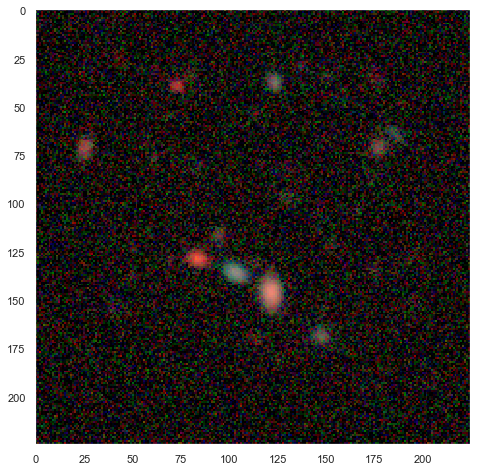

In [80]:
nonlin = 0.15
scales = np.array([1, 1.25, 1.1]) * 0.0025

r, c = des_mbobs[0][0].image.shape
colorim = np.zeros((r, c, 3))
get_color_image(
    des_mbobs[2][0].image,
    des_mbobs[1][0].image,
    des_mbobs[0][0].image,
    nonlin, 
    scales, 
    colorim)

final_img = (colorim * 255).astype('u1')

plt.figure(figsize=(8, 8))
plt.imshow(final_img)
plt.gca().grid(False)


from PIL import Image
kw = {}
pim = Image.fromarray(final_img)
kw['quality'] = 90
pim.save("des_gri.jpg", **kw)

In [81]:
%%time

LSST_CONFIG = {
    'gal_type': 'wldeblend',
    'psf_type': 'wldeblend',
    'shear_scene': True,
    'scale': 0.2,
    'dim': 300,    
    'n_coadd_psf': 1,
    'gal_kws': {
        'survey_name': 'LSST',
        'bands': ('g', 'r', 'i',)},    
}

lsst_sim = Sim(
    rng=np.random.RandomState(),
    **LSST_CONFIG,
    g1=0.0)

lsst_mbobs = lsst_sim.get_mbobs()

CPU times: user 4.53 s, sys: 277 ms, total: 4.81 s
Wall time: 4.86 s


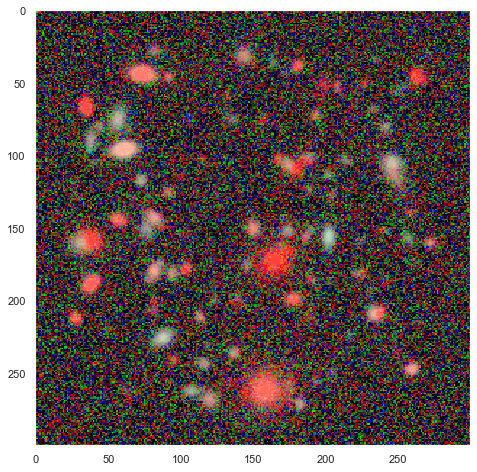

In [109]:
nonlin = 0.15
scales = np.array([1, 1.9, 1.1 * np.sqrt(5520/2400)]) * 0.0025

r, c = lsst_mbobs[0][0].image.shape
colorim = np.zeros((r, c, 3))
get_color_image(
    lsst_mbobs[2][0].image,
    lsst_mbobs[1][0].image,
    lsst_mbobs[0][0].image,
    nonlin, 
    scales, 
    colorim)

final_img = (colorim * 255).astype('u1')

plt.figure(figsize=(8, 8))
plt.imshow(final_img)
plt.gca().grid(False)


from PIL import Image
kw = {}
pim = Image.fromarray(final_img)
kw['quality'] = 90
pim.save("lsst_gri.jpg", **kw)

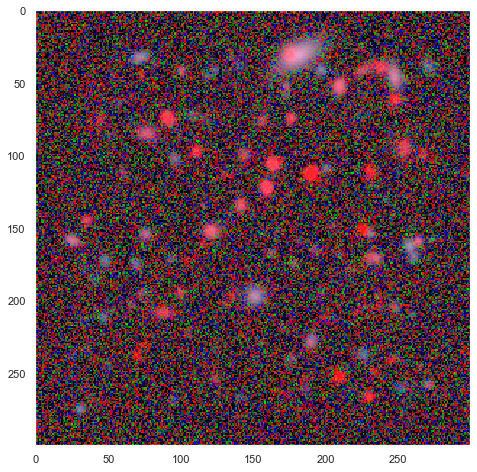

In [50]:
nonlin = 0.12
scales = np.array([1.5, 2, 2.5]) * 0.0025

colorim = np.zeros((300, 300, 3))
get_color_image(
    lsst_mbobs[2][0].image,
    lsst_mbobs[1][0].image,
    lsst_mbobs[0][0].image,
    nonlin, 
    scales, 
    colorim)

final_img = (colorim * 255).astype('u1')

plt.figure(figsize=(8, 8))
plt.imshow(final_img)
plt.gca().grid(False)

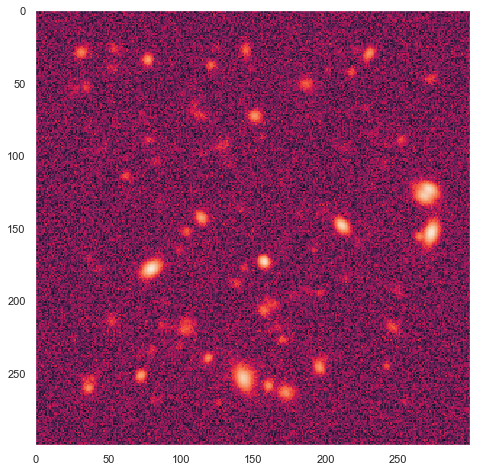

In [214]:
plt.figure(figsize=(8, 8))
plt.imshow(np.arcsinh(lsst_mbobs[0][0].image/np.std(lsst_mbobs[0][0].noise)))
plt.gca().grid(False)

In [104]:
np.std(des_mbobs[0][0].noise)

104.33121061950031

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))

for band in range(3):
    for epoch in range(2):
        ax = axs[band, epoch]
        msk = ims[band][epoch] > 1e11
        std = np.std(ims[band][epoch][~msk])
        imc = ims[band][epoch].copy()
        imc[msk] = np.nan
        ax.imshow(np.arcsinh(imc/std))
        ax.grid(False)
        
        if epoch == 0:
            ax.set_ylabel('band %d' % band)
        
        if band == 0:
            ax.set_title('epoch %d' % epoch)
    
    ax = axs[band][2]
    ax.imshow(np.arcsinh(mbobs[band][0].image / np.std(mbobs[band][0].noise)))
    ax.grid(False)
    if band == 0:
        ax.set_title('coadd')

    ax = axs[band][3]
    ax.imshow(mbobs[band][0].meta['fmask'], vmin=0, vmax=1)
    ax.grid(False)
    if band == 0:
        ax.set_title('interp. frac')

    ax = axs[band][4]
    ax.imshow(np.arcsinh(mbobs[band][0].noise / np.std(mbobs[band][0].noise)))
    ax.grid(False)
    if band == 0:
        ax.set_title('noise coadd')


plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(mbobs[0][0].psf.image[12:-12, 12:-12])
plt.gca().grid(False)

In [ ]:
band = 0

plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.imshow(np.arcsinh(mbobs[band][0].psf.image[26-11:26+12, 26-11:26+12]))
ax.grid(False)

from galsim.hsm import FindAdaptiveMom

psf_im = galsim.ImageD(mbobs[band][0].psf.image, scale=sim.scale)
admom = FindAdaptiveMom(psf_im)
print(admom.observed_shape, psf_im.calculateFWHM())

In [ ]:
from scipy.interpolate import approximate_taylor_polynomial, pade

In [ ]:
order = 20
porder = order // 2

t = approximate_taylor_polynomial(lambda x: np.sinc(x)/(x-1)/(x-2)/(x-3), 0, order, 3.01, order=order+8)

p, q = pade(t.coefficients[::-1], porder)

def sinc_pade(x):
    return p(x) / q(x) * (x-1) * (x-2) * (x-3)

In [ ]:
al = 3
x = np.linspace(0, al, 10000)

plt.figure()
if False:
    plt.plot(x, np.sinc(x) * np.sinc(x/al), label='true')
    plt.plot(x, sinc_pade(x) * sinc_pade(x/al), label='pade')
else:
    plt.plot(x, sinc_pade(x) * sinc_pade(x/al) - np.sinc(x) * np.sinc(x/al), label='pade')
plt.legend()

for _x in [0, 1, 2, 3]:
    print(_x, sinc_pade(_x) * sinc_pade(_x/al))

print(np.max(np.abs(sinc_pade(x) * sinc_pade(x/al) - np.sinc(x) * np.sinc(x/al))))

In [ ]:
from numba import njit

In [ ]:
def _make_code(poly):
    d = []
    for p, c in enumerate(poly.coef[::-1]):
        d.append('%0.15g + x * (' % (c))

    print('\n'.join(d))

In [ ]:
_make_code(p)
_make_code(q)

In [ ]:
@njit
def sinc_pade(x):
    x = np.abs(x)

    num = (  # noqa
        -0.166666666666666 + x * (
        -0.289176685343373 + x * (
        -0.109757669089546 + x * (
        0.0350931080575596 + x * (
        0.0229947584643336 + x * (
        -0.00089363958201935 + x * (
        -0.00162722192965722 + x * (
        -3.00689146075626e-05 + x * (
        5.13864469774294e-05 + x * (
        1.23561563382214e-06 + x * (
        -6.37392253619041e-07))))))))))) * (x-1) * (x-2) * (x-3)
    den = (  # noqa
        1 + x * (
        -0.0982732212730775 + x * (
        0.122536542608403 + x * (
        -0.0111525324680647 + x * (
        0.00724707512833019 + x * (
        -0.000584774445653404 + x * (
        0.000262528048296579 + x * (
        -1.71596576734417e-05 + x * (
        5.91945411660804e-06 + x * (
        -2.44174818579491e-07 + x * (
        6.74473938075399e-08)))))))))))
    return num / den

@njit
def sinc(x):
    return np.sinc(x)

In [ ]:
al = 3
x = np.linspace(-al, al, 10000)

plt.figure()
if False:
    plt.plot(x, np.sinc(x) * np.sinc(x/al), label='true')
    plt.plot(x, sinc_pade(x) * sinc_pade(x/al), label='pade')
else:
    plt.plot(x, sinc_pade(x) * sinc_pade(x/al) - np.sinc(x) * np.sinc(x/al), label='pade')
plt.legend()

for _x in [0, 1, 2, 3]:
    print(_x, sinc_pade(_x) * sinc_pade(_x/al))
    
print(np.max(np.abs(sinc_pade(x) * sinc_pade(x/al) - np.sinc(x) * np.sinc(x/al))))

In [ ]:
%%timeit

sinc(x) * sinc(x/al)

In [ ]:
%%timeit

sinc_pade(x) * sinc_pade(x/al)

In [ ]:
np.max(mbobs[band][0].meta['fmask'])